In [1]:
import numpy as np
import matplotlib.pyplot as plt
from typing import Tuple, List, Dict
from tqdm import tqdm
import random

In [2]:
class Terrain:

    def __init__(self, dimension: int, origin: tuple, target: tuple):
        # Grid - 0 is barrier, 1 is open area
        self.grid = np.random.randint(0, 5, (dimension, dimension))
        self.grid = np.where(self.grid > 0, 1, 0)

        # Origin and Target
        self.origin = origin
        self.target = target
        self.grid[origin] = 1
        self.grid[target] = 1

        # Movement Options
        self.movement_count = 4
        self.movement_map = {
            0: "North",
            1: "South",
            2: "West",
            3: "East"
        }

    # Executes a move and returns the next location, reward
    def advance(self, position: tuple, move: int):

        x, y = position

        if move == 0: # North
            x = max(x - 1, 0)
        elif move == 1: # South
            x = min(x + 1, self.grid.shape[0] - 1)
        elif move == 2: # West
            y = max(y - 1, 0)
        elif move == 3: # East
            y = min(y + 1, self.grid.shape[1] - 1)

        finished = False
        new_position = (x, y)

        if new_position == self.target:
            reward = 100
            finished = True
        elif self.grid[new_position] == 0: # Barrier
            reward = -100
            new_position = position # Remain in the same position
        elif new_position == position:
            reward = -100 # Penalty for not moving
        else:
            reward = -10

        return new_position, reward, finished

    def display(self):
        plt.imshow(self.grid, cmap='gray')
        plt.title('2D Terrain Grid')
        plt.show()

In [3]:
class Agent:
    def __init__(self, terrain: Terrain, gamma: float, alpha: float, epsilon: float):
        self.terrain = terrain
        self.gamma = gamma
        self.alpha = alpha
        self.epsilon = epsilon
        # Biased Q

        self.q_table = np.zeros((terrain.grid.shape[0], terrain.grid.shape[1], terrain.movement_count))
        for i in range(terrain.grid.shape[0]):
            for j in range(terrain.grid.shape[1]):
                if terrain.grid[i][j] == 0:

                    # Left cell
                    if j > 0 and terrain.grid[i][j-1] == 1:
                        self.q_table[i][j-1][3] = -1000
                    # Right cell
                    if j < terrain.grid.shape[1] - 1 and terrain.grid[i][j+1] == 1:
                        self.q_table[i][j+1][2] = -1000
                    # Up cell
                    if i > 0 and terrain.grid[i-1][j] == 1:
                        self.q_table[i-1][j][1] = -1000
                    # Down cell
                    if i < terrain.grid.shape[0] - 1 and terrain.grid[i+1][j] == 1:
                        self.q_table[i+1][j][0] = -1000

    # Epsilon Greedy Policy
    def choose_action(self, state: tuple):
        if np.random.uniform(0, 1) < self.epsilon:
            return np.random.choice(self.terrain.movement_count)
        else:
            return np.argmax(self.q_table[state])

    # Q-Learning
    def update(self, state: tuple, action: int, reward: float, next_state: tuple):
        predict = self.q_table[state][action]
        target = reward + self.gamma * np.max(self.q_table[next_state])
        self.q_table[state][action] += self.alpha * (target - predict)


    def train(self, episodes: int):

        for episode in tqdm(range(episodes), desc="Training Progress"):
            done = False
            steps = 0
            state = self.terrain.origin

            while not done:
                action = self.choose_action(state)
                next_state, reward, done = self.terrain.advance(state, action)
                self.update(state, action, reward, next_state)
                state = next_state
                steps += 1

        print('Training Completed!')

    def get_optimal_policy(self):
        policy = [[None for _ in range(self.terrain.grid.shape[1])] for _ in range(self.terrain.grid.shape[0])]
        for i in range(self.terrain.grid.shape[0]):
            for j in range(self.terrain.grid.shape[1]):
                max_indices = np.argwhere(self.q_table[i][j] == np.max(self.q_table[i][j])).flatten().tolist()
                policy[i][j] = max_indices
        return policy

    def visualize_optimal_policy(self):
        paths = []
        policy = self.get_optimal_policy()

        def backtrack(state, path):

            if len(paths) > 10:
                return

            if state == self.terrain.target:
                paths.append(path.copy())
                return

            for action in policy[state[0]][state[1]]:
                next_state, _, _ = self.terrain.advance(state, action)

                if next_state in path:
                    continue

                path.append(next_state)
                backtrack(next_state, path)
                path.pop()

        backtrack(self.terrain.origin, [self.terrain.origin])

        if len(paths) == 0:
            plt.title('No Optimal Path Found!')

        for idx, path in enumerate(paths):
            grid = 1 - self.terrain.grid.copy()
            for i, j in path:
                grid[i][j] = 2

            plt.title(f'Optimal Path {idx+1}')
            plt.imshow(grid, cmap=plt.colormaps.get_cmap('Reds'))
            plt.show()

            if idx == 10:
                break

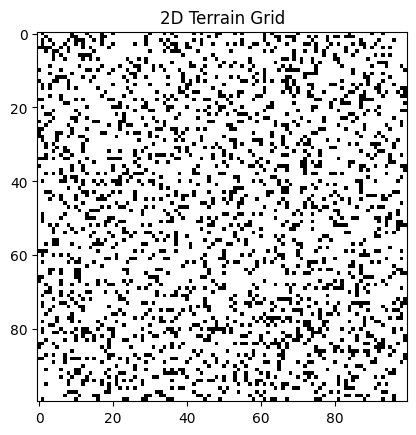

In [4]:
SIZE = 100

terrain = Terrain(dimension=SIZE, origin=(0, 0), target=(SIZE-1, SIZE-1))
agent = Agent(terrain, gamma=0.9, alpha=0.1, epsilon=0.3)

terrain.display()

In [ ]:
agent.train(episodes=10000)

Training Progress:   0%|          | 0/10000 [00:00<?, ?it/s]

In [ ]:
agent.visualize_optimal_policy()